# Projeto oficial Disciplina Python: 

## Introdução
Como variações no tamanho da rede do volêi masculino alteram a performance (pontos, bloqueios, saques) dos jogadores?
Sabemos que o volêi moderno, especialmenete o masculino, evoluiu bastante em termos de performances dos jogadores. No sentido de que não há equipes em que os jogadores de ataque (ponteiros, opostos, levantadores) não ultrapassem facilmente os 3,30 cm de salto durante o ataque ou bloqueio. Isto considerando uma rede com altura de 2,43 cm é quase 1 metro de diferença. A competitividade a esse ponto elevou o nível do jogo a um patamar nunca antes visto na história do volêi mundial. Mesmo os jogadores de ataque com alturas inferiores a 1,90 cm (que sãp oconsiderados relativamente baixos para os padrões atuais) possuem bastante facilidade para atingir alturas de até 1 metro acima do limite superior da rede. 

O mais impressionante é que a performance desses jogadores consegue ser mantida quase sempre durante todo os sets do jogo, independentemente se são jogados em 3 sets ou 5 em caso de tie-break. A disputa nos dias atuais portanto é em força, velocidade, e impulsão e por ultimo habilidade. Apesar de soar controlverso, muito se tem discutido que o volei masculino preza sobretudo por muitas outras caracteristicas em detrimento da habilidade e destresa da performance, justamente pelo fato da altura (algo endógeno e inato do jogador) e força serem fatores preponderantes sobre outras características. Obviamente isto não supera um equilíbrio entre todo o conjunto de caracteristicas, pois um exceletne jogador possui bons fundamentos adquiridos com treinos somados a ter uma boa altura e capacidade física. 

Isto é um fato, apenas altura e força não bastam. Entretando a medida em que elas são capazes de determinar o que é seria um "bom jogador" é algo que revela o quão determinantes para isso elas são. 

Com isso, vou tentar fazer um modelo me machine learning para prever como a performance dos jogadores é alterada com aumentos marginais (cm) na altura da rede. Isso lhes trás mais vantagem? Quais tipos de jogadores se beneficiariam mais? É correto dizer que isso é bom para o esporte como um todo ou só está punindo aqueles que possuem uma característica inata que lhes da maior vantagem sobre os outros? Essas e outras perguntas motivaram este estudo e ao longo das próximas células irei tentar esclarecêlas.

## Datasets

Vamos utilizar dois datasets: o primeiro dataset é um overall de todos os players da liga de volei polonêsa, o segundo é também um overall de todos os jogadores atuando na liga Japonesa na temporada 23/24. No dataset da liga polonesa o periodo das estatísticas vai desde a temporada 00/01 até a temporada 23/24 (atual). Já no dataset da liga japonesa temos o periodo apenas de 23/24 com todas as estatísticas de todos os jogadores, estejam eles atuando há mais temporadas ou na sua primeira temporada.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import json

name = "PLAYERS_BIO_MEN'S_PLUS_LEAGUE_ALL_STATS.json"
with open(name, 'r') as json_file:
    dt = json.load(json_file)
    

poland = pd.DataFrame(dt)

name1 = "MEN'S_JAPANESE_LEAGUE_ALL_STATS"
with open(name1, 'r') as json_file1:
    df = json.load(json_file1)
    

japanese = pd.DataFrame(df)





Fazendo algumas manipulações no dataset para obter o conjunto ideal de dados para a análise

In [2]:
poland.replace(',', '.', regex=True, inplace=True)
poland.replace(" ", "", regex=True, inplace=True)
poland.replace('','0',regex=True, inplace=True)
poland.replace("'",'',regex=True,inplace=True)
japanese.replace('','0',regex=True, inplace=True)


Colocando uma coluna representando a altura oficial da rede de vôlei (243 cm) e tirando a diferença to salto de cada jogador para a rede e do salto do jogador para a própria altura para descobrir o quanto ele salta.

In [3]:
poland['net_size_current'] = '243'
poland['diff_net_player_jump'] = poland['player_jump_height_cm'].astype(int) - poland['net_size_current'].astype(int)
poland['diff_player_jump_to_heigh'] = poland['player_jump_height_cm'].astype(int) - poland['player_height_cm'].astype(int)

japanese['net_size_current'] = '243'
japanese['diff_net_player_jump'] = japanese['player_jump_heighest'].astype(float) - japanese['net_size_current'].astype(int)
japanese['diff_player_jump_to_heigh'] = japanese['player_jump_heighest'].astype(float) - japanese['player_heigh_cm'].astype(float)

Um fato interessante a se observar é a média de altura dos jogadores de cada liga. Na liga polonesa a média de altura é 194,15 cm, ja na liga japonesa é de 187,99 cm. Isto pode refletir principalmente na eficiencia do ataque (ataques/tentativas).

In [4]:
poland_mean = poland['player_height_cm'].astype(int).mean()
japanese_mean = japanese['player_heigh_cm'].astype(float).mean()

print(japanese_mean, poland_mean)



187.98232044198897 194.14615384615385


Traduzindo os nomes das posições para inglês

In [4]:
poland['player_position'] = poland['player_position'].replace({
    'Środkowy': 'Middle',
    'Przyjmujący': 'Outside Hitter',
    'Libero': 'Libero',
    'Rozgrywający': 'Setter',
    'Atakujący': 'Opposite Hitter'
})

japanese['position'] = japanese['position'].map({
    'オポジット': 'Opposite Hitter',
    'セッター': 'Setter',
    'アウトサイドヒッター': 'Outside Hitter',
    'ミドルブロッカー': 'Middle Blocker',
    'リベロ': 'Libero'
})

Agora vamos considerar apenas jogadores que ocupam posições na linha de ataque, isto é: Middles, Outside Hitters e Opposite Hitters. Fazemos isto pois é a partir da análise da performance desses jogadores nessas posições que podemos traçar o caminho para entender mais sobre o que estamos interessados, isto é, entender como uma mudança na altura da rede afetaria os jogadores dessas posições.

In [5]:
poland_oficial = poland[poland['player_position'].isin(['Middle', 'Outside Hitter', 'Opposite Hitter'])]
japanese_oficial = japanese[japanese['position'].isin(['Middle', 'Outside Hitter', 'Opposite Hitter'])]


In [6]:
poland_oficial['points'].fillna(0, inplace=True)
poland_oficial['points'] = poland_oficial['points'].astype(int)
mean_jump_height = poland_oficial['player_jump_height_cm'].mean()
poland_oficial['player_jump_height_cm'].fillna(mean_jump_height, inplace=True)


C:\Users\estev\AppData\Local\Temp\ipykernel_21688\1543077272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poland_oficial['points'].fillna(0, inplace=True)
C:\Users\estev\AppData\Local\Temp\ipykernel_21688\1543077272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poland_oficial['points'] = poland_oficial['points'].astype(int)
C:\Users\estev\AppData\Local\Temp\ipykernel_21688\1543077272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [51]:
japanese_oficial['points'].fillna(0, inplace=True)
mean_jump_height = japanese_oficial['player_jump_heighest'].mean()
japanese_oficial['player_jump_heighest'].fillna(mean_jump_height, inplace=True)
japanese_oficial


C:\Users\estev\AppData\Local\Temp\ipykernel_13160\1332193648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japanese_oficial['points'].fillna(0, inplace=True)
C:\Users\estev\AppData\Local\Temp\ipykernel_13160\1332193648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japanese_oficial['player_jump_heighest'].fillna(mean_jump_height, inplace=True)


,position,player_name,player_born,player_heigh_cm,player_wight_kg,player_finger_point_heigh,player_jump_heighest,player_jump_diff_heigh,player_league,matches_played,...,block_points,plock_points_perset,serves,aces,reception,reception_perfect,reception_sucsess_rate,net_size_current,diff_net_player_jump,diff_player_jump_to_heigh
0,Opposite Hitter,SHIMIZU,1986-08-11,193,98,260,340,80,japanese_league,426,...,431,0.33,4973,335,119,73,50.4,243,97.0,147.0
3,Outside Hitter,JAESCHKE,1993-09-04,200,93,250,354,70,japanese_league,34,...,47,0.45,395,41,622,478,65.2,243,111.0,154.0
4,Outside Hitter,TARUMI,2000-11-02,187,81,239,350,85,japanese_league,39,...,1,0.07,30,4,48,31,53.1,243,107.0,163.0
5,Outside Hitter,NAKAMOTO,1997-11-21,187,80,240,330,95,japanese_league,142,...,33,0.16,653,17,1011,704,58.0,243,87.0,143.0
6,Outside Hitter,IMAMURA,1993-05-20,193,91,255,340,85,japanese_league,194,...,29,0.14,326,12,75,41,42.7,243,97.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Opposite Hitter,XIU,1999-08-23,203,90,265,365,77,japanese_league,32,...,41,0.40,299,9,2,0,0.0,243,122.0,162.0
170,Outside Hitter,FUJIWARA,1998-07-14,190,84,243,330,60,japanese_league,108,...,30,0.11,776,17,1621,972,47.1,243,87.0,140.0
171,Outside Hitter,KUDO,2001-09-24,190,80,243,335,70,japanese_league,44,...,31,0.24,493,34,1023,695,53.4,243,92.0,145.0
177,Outside Hitter,KEITO,1999-07-15,190,83,245,340,80,japanese_league,95,...,7,0.04,162,4,85,40,38.8,243,97.0,150.0


In [8]:
pd.to_numeric(poland_oficial['points'])
pd.to_numeric(poland_oficial['player_height_cm'])
pd.to_numeric(poland_oficial['player_jump_height_cm'])
pd.to_numeric(poland_oficial['player_weight_kg'])
poland_oficial

,matches_played,sets_played,points,serves,aces,serves_mistakes,aces_per_set,reception,reception_mistakes,reception_bad,...,player_name,player_age,player_height_cm,player_weight_kg,player_jump_height_cm,player_position,player_id,net_size_current,diff_net_player_jump,diff_player_jump_to_heigh
0,43,141,161,404,25,78,0.1773,45,5,20,...,JakubAbramowicz,10/04/1998,202,90,350,Middle,2100171,243,107,148
1,20,72,222,290,12,38,0.1667,431,40,128,...,AdrianAciobăniței,24/08/1997,193,78,337,Outside Hitter,2124367,243,94,144
2,43,116,203,337,12,71,0.1034,65,7,11,...,SebastianAdamczyk,28/02/1999,208,98,350,Middle,27975,243,107,142
3,19,61,116,126,11,34,0.1803,145,13,35,...,ManuelArmoa,01/12/2002,198,84,330,Outside Hitter,2125173,243,87,132
4,63,216,501,804,45,151,0.2083,24,2,5,...,TaylorAverill,05/03/1992,201,93,370,Middle,2102337,243,127,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,JustinZiółkowski,09/06/1998,196,90,330,Outside Hitter,2135146,243,87,134
256,371,1348,2413,4722,211,453,0.1565,328,20,62,...,MiłoszZniszczoł,02/07/1986,201,102,345,Middle,372,243,102,144
257,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,BartoszZych,15/07/2006,203,86,353,Outside Hitter,2115603,243,110,150
258,40,82,57,56,3,13,0.0366,1,0,1,...,ArkadiuszŻakieta,13/10/1992,197,94,355,Opposite Hitter,2100071,243,112,158


In [9]:
poland_oficial.fillna('0', inplace=True)
poland_oficial

C:\Users\estev\AppData\Local\Temp\ipykernel_21688\139280492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poland_oficial.fillna('0', inplace=True)


,matches_played,sets_played,points,serves,aces,serves_mistakes,aces_per_set,reception,reception_mistakes,reception_bad,...,player_name,player_age,player_height_cm,player_weight_kg,player_jump_height_cm,player_position,player_id,net_size_current,diff_net_player_jump,diff_player_jump_to_heigh
0,43,141,161,404,25,78,0.1773,45,5,20,...,JakubAbramowicz,10/04/1998,202,90,350,Middle,2100171,243,107,148
1,20,72,222,290,12,38,0.1667,431,40,128,...,AdrianAciobăniței,24/08/1997,193,78,337,Outside Hitter,2124367,243,94,144
2,43,116,203,337,12,71,0.1034,65,7,11,...,SebastianAdamczyk,28/02/1999,208,98,350,Middle,27975,243,107,142
3,19,61,116,126,11,34,0.1803,145,13,35,...,ManuelArmoa,01/12/2002,198,84,330,Outside Hitter,2125173,243,87,132
4,63,216,501,804,45,151,0.2083,24,2,5,...,TaylorAverill,05/03/1992,201,93,370,Middle,2102337,243,127,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,0,0,0,0,0,0,0,0,0,...,JustinZiółkowski,09/06/1998,196,90,330,Outside Hitter,2135146,243,87,134
256,371,1348,2413,4722,211,453,0.1565,328,20,62,...,MiłoszZniszczoł,02/07/1986,201,102,345,Middle,372,243,102,144
257,0,0,0,0,0,0,0,0,0,0,...,BartoszZych,15/07/2006,203,86,353,Outside Hitter,2115603,243,110,150
258,40,82,57,56,3,13,0.0366,1,0,1,...,ArkadiuszŻakieta,13/10/1992,197,94,355,Opposite Hitter,2100071,243,112,158


Plotando a regressão de numero de pontos vs impulsão do jogador (diferença entre a  altura do salto e a altura do jogador) para os jogadores da liga japonesa

C:\Users\estev\AppData\Local\Temp\ipykernel_13160\1002475033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japanese_oficial['matches_played'] = pd.to_numeric(japanese_oficial['matches_played'], errors='coerce')
C:\Users\estev\AppData\Local\Temp\ipykernel_13160\1002475033.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[cols_to_convert] = data_filtered[cols_to_convert].astype(int)


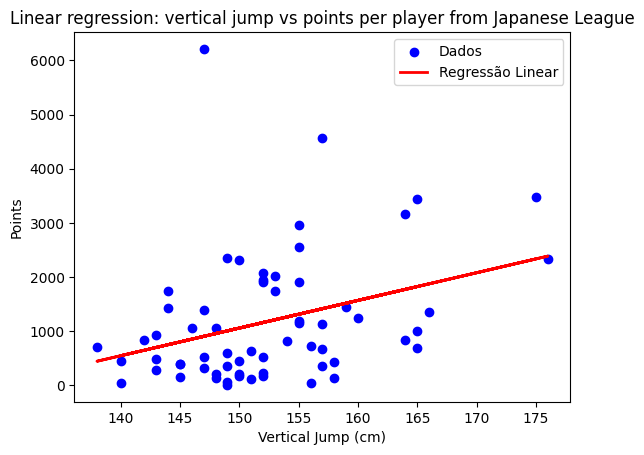

In [54]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Convertendo 'matches_played' para tipo numérico
japanese_oficial['matches_played'] = pd.to_numeric(japanese_oficial['matches_played'], errors='coerce')

# Filtrar jogadores com mais de 40 partidas jogadas
data_filtered = japanese_oficial[japanese_oficial['matches_played'] > 40]

# Selecionar as colunas desejadas
cols_to_convert = ['diff_player_jump_to_heigh', 'player_heigh_cm', 'player_wight_kg', 'points']

# Converter as colunas relevantes para int
data_filtered[cols_to_convert] = data_filtered[cols_to_convert].astype(int)

# Criar o modelo de regressão linear
X = sm.add_constant(data_filtered['diff_player_jump_to_heigh']) # Adicionando uma constante para o termo independente
y = data_filtered['points']
model = sm.OLS(y, X)

# Ajustar o modelo aos dados
results = model.fit()

# Scatter plot dos dados
plt.scatter(data_filtered['diff_player_jump_to_heigh'], data_filtered['points'], color='blue', label='Dados')

# Plot da linha de regressão
plt.plot(data_filtered['diff_player_jump_to_heigh'], results.predict(X), color='red', linewidth=2, label='Regressão Linear')

# Adicionar rótulos e título
plt.xlabel('Vertical Jump (cm)')
plt.ylabel('Points')
plt.title('Linear regression: vertical jump vs points per player from Japanese League')
plt.legend()

# Mostrar o gráfico
plt.show()


Plotando a regressão de numero de pontos vs impulsão do jogador (diferença entre a  altura do salto e a altura do jogador) para os jogadores da liga polonesa

C:\Users\estev\AppData\Local\Temp\ipykernel_21688\345578332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poland_oficial['matches_played'] = pd.to_numeric(poland_oficial['matches_played'], errors='coerce')
C:\Users\estev\AppData\Local\Temp\ipykernel_21688\345578332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poland_oficial['diff_player_jump_to_heigh'] = pd.to_numeric(poland_oficial['diff_player_jump_to_heigh'], errors='coerce')
C:\Users\estev\AppData\Local\Temp\ipykernel_21688\345578332.py:8: 

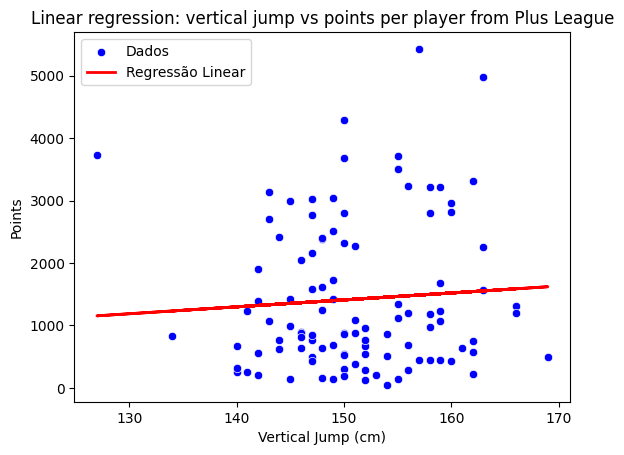

In [14]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Convertendo 'matches_played' para tipo numérico
poland_oficial['matches_played'] = pd.to_numeric(poland_oficial['matches_played'], errors='coerce')
poland_oficial['diff_player_jump_to_heigh'] = pd.to_numeric(poland_oficial['diff_player_jump_to_heigh'], errors='coerce')
poland_oficial['points'] = pd.to_numeric(poland_oficial['points'], errors='coerce')
# Filtrar jogadores com mais de 40 partidas jogadas
data_filtered = poland_oficial[poland_oficial['matches_played'] > 40]

# Selecionar as colunas desejadas
cols_to_convert = ['diff_player_jump_to_heigh', 'player_height_cm', 'player_weight_kg', 'points']

# Converter as colunas relevantes para int
data_filtered[cols_to_convert] = data_filtered[cols_to_convert].astype(int)

# Criar o modelo de regressão linear
X = sm.add_constant(data_filtered['diff_player_jump_to_heigh']) # Adicionando uma constante para o termo independente
y = data_filtered['points']
model = sm.OLS(y, X)

# Ajustar o modelo aos dados
results = model.fit()

# Scatter plot dos dados
sns.scatterplot(data=data_filtered, x='diff_player_jump_to_heigh', y='points', color='blue', label='Dados')

# Plot da linha de regressão
plt.plot(data_filtered['diff_player_jump_to_heigh'], results.predict(X), color='red', linewidth=2, label='Regressão Linear')

# Adicionar rótulos e título
plt.xlabel('Vertical Jump (cm)')
plt.ylabel('Points')
plt.title('Linear regression: vertical jump vs points per player from Plus League')
plt.legend()

# Mostrar o gráfico
plt.show()
